## Import libraries and modules

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

## Create a spark session object

In [2]:
spark = (SparkSession.builder
         .appName("text-processing")
         .master("spark://spark-master:7077")
         .config("spark.executor.memory", "512m")
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/03 16:06:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.sparkContext.setLogLevel("ERROR")

## Load the data

In [4]:
df = (spark.read.format("csv")
      .option("header", "true")
      .option("multiLine", "true")
      .load("../../data/Reviews.csv"))

In [5]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [6]:
df.show(5, truncate=False)

+------+----------+--------------+----------------------------------+--------------------+----------------------+-----+----------+----------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id    |ProductId |UserId        |ProfileName    

## Clean data with regular expressions

In [7]:
df_clean = (df.withColumn("Text", regexp_replace("Text", "[^a-zA-Z ]", ""))
            .withColumn("Text", regexp_replace("Text", " +", " "))
           )

df_clean.show(5, truncate=False)

+------+----------+--------------+----------------------------------+--------------------+----------------------+-----+----------+----------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id    |ProductId |UserId        |ProfileName                       |HelpfulnessNumerator

## Tokenize the text data

### Using built-in tokenizer in MLlib library

In [8]:
from pyspark.ml.feature import Tokenizer

In [9]:
tokenizer = Tokenizer(inputCol='Text', 
                      outputCol='words')

df_with_words = tokenizer.transform(df_clean)

df_with_words.show()

+------+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------------+
|    Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|               words|
+------+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+--------------------+
|250093|B0029NII3C|A3P8CU9874SRK5|        C. christine|                   0|                     0|    2|1316649600|Unwanted Ingredients|I was interested ...|[i, was, interest...|
|250115|B0013MEB40| A99TG4Q2ZPW7S|"Blu-estLight ""M...|                   0|                     0|    4|1310083200|one of my favorit...|These cookies are...|[these, cookies, ...|
|250132|B005UBH8WC| AY12DBB0U420B|       Gary Peterson|                   0|                     0| 

## Remove stop words

In [10]:
from pyspark.ml.feature import StopWordsRemover

In [11]:
remover = StopWordsRemover(inputCol='words',
                           outputCol='filtered_words')

df_stop_words_removed = remover.transform(df_with_words)

df_stop_words_removed.show(5, truncate=False)

+------+----------+--------------+----------------------------------+--------------------+----------------------+-----+----------+----------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------

## Compute word frequency

In [12]:
df_exploded = (df_stop_words_removed.select(explode(df_stop_words_removed.filtered_words)
                                           .alias('word')))

word_count = (df_exploded.groupBy("word")
              .count()
              .orderBy("count", ascending=False))

word_count.show(n=100)


+---------+-----+
|     word|count|
+---------+-----+
|     like| 2856|
|       br| 2761|
|     good| 2278|
|    great| 1979|
|      one| 1938|
|    taste| 1909|
|  product| 1733|
|   coffee| 1663|
|   flavor| 1614|
|     love| 1537|
|      tea| 1528|
|     food| 1289|
|      get| 1158|
|   really| 1151|
|     dont| 1070|
|     much| 1031|
|      use| 1010|
|     also|  981|
|   amazon|  971|
|     time|  962|
|   little|  910|
|    tried|  899|
|     best|  891|
|      buy|  863|
|    price|  862|
|      ive|  858|
|       im|  825|
|     even|  822|
|     make|  811|
|     well|  809|
|     find|  807|
|   better|  790|
|      try|  747|
|chocolate|  726|
|      eat|  720|
|    water|  697|
|     used|  665|
|      dog|  644|
|    first|  628|
|    sweet|  623|
|    drink|  623|
|   bought|  621|
|    found|  617|
|     made|  575|
|   tastes|  573|
|      two|  569|
|      bag|  567|
|      cup|  559|
|      way|  541|
|    think|  540|
|    sugar|  531|
|delicious|  521|
|      box

## Convert text to numerical features

In [13]:
from pyspark.ml.feature import CountVectorizer

In [14]:
vectorizer = CountVectorizer(inputCol = 'filtered_words',
                             outputCol= 'features')

vectorized_data = vectorizer.fit(df_stop_words_removed).transform(df_stop_words_removed)

vectorized_data.show(5, truncate=False)

+------+----------+--------------+----------------------------------+--------------------+----------------------+-----+----------+----------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------

In [15]:
spark

## Save the processed data

(vectorized_data.repartition(1)
 .write.mode("overwrite")
 .json("./vector_data/reviews_vectorized.json"))

In [16]:
! pip install wordcloud matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.6/27.6 MB 3.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 3.6 MB/s eta 0:00:00a 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.9.4-cp310-cp310-linux_aarch64.whl size=431103 sha256=636b455bc5419883584ab7e398444e668d2e7dba1a14feaf10c222aa3c1ba724
  Stored in directory: /root/.cache/pip/wheels/ed/c8/65/bf28b4074899d282ed1f67957f590ccb92f0fdcd27d95399c1
Successfully built wordcloud


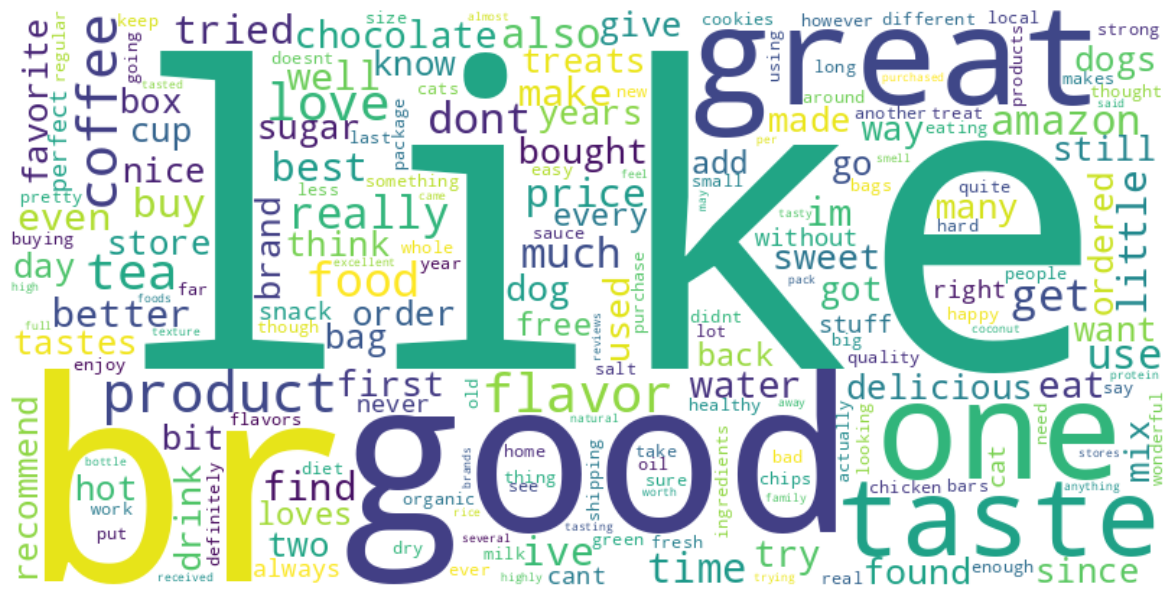

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Convert the DataFrame word_count into a Python dictionary
word_freq = {row['word']: row['count'] for row in word_count.collect()}

# Create a WordCloud object from the frequency dictionary
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud using matplotlib
plt.figure(figsize=(15, 7.5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide axis details
plt.show()